In [54]:
# Libraries 
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

In [55]:
cd/Users/yeji-park/Downloads/Time_Series_Analysis_CO2/Datasets

/Users/yeji-park/Downloads/Time_Series_Analysis_CO2/Datasets


In [56]:
train = pd.read_csv('df.csv')
train

,Country,Year,CO2_per_capita,GDP,CarbonTaxDummy
0,Argentina,1983,3.579042,3727.048010,1
1,Argentina,1984,3.568349,3787.470679,1
2,Argentina,1985,3.319273,2919.283511,1
3,Argentina,1986,3.387178,3454.296334,1
4,Argentina,1987,3.680022,3492.691474,1
...,...,...,...,...,...
2171,United States,2018,16.191355,62823.309438,0
2172,United States,2019,15.739861,65120.394663,0
2173,United States,2020,14.034053,63528.634303,0
2174,United States,2021,14.932488,70219.472454,0


# Test Dataset 1 

In [57]:
# Create a DataFrame with years from 2022 to 2033 for the United States
test = pd.DataFrame({'Year': range(2022, 2034)})
test['Country'] = 'United States'

# Initialize CO2_per_capita and GDP columns with NaN values
test['CO2_per_capita'] = pd.NA
test['GDP'] = pd.NA
test['CarbonTaxDummy'] = 0

# Calculate the average annual increase in GDP
gdp_diff = train.loc[train['Country'] == 'United States', 'GDP'].diff().mean()

if not train.empty:
    # Get the GDP value for the last available year in the train DataFrame for the United States
    last_year_gdp = train.loc[train['Country'] == 'United States', 'GDP'].max()

    # Calculate the GDP values for the years 2023 to 2032 based on the average increase
    test.loc[test['Year'] >= 2022, 'GDP'] = last_year_gdp + gdp_diff * (test['Year'] - train['Year'].max())

else:
    print("No data available for the United States in the train DataFrame.")

test

,Year,Country,CO2_per_capita,GDP,CarbonTaxDummy
0,2022,United States,<NA>,76329.582265,0
1,2023,United States,<NA>,77512.202569,0
2,2024,United States,<NA>,78694.822872,0
3,2025,United States,<NA>,79877.443176,0
4,2026,United States,<NA>,81060.063479,0
5,2027,United States,<NA>,82242.683783,0
6,2028,United States,<NA>,83425.304086,0
7,2029,United States,<NA>,84607.92439,0
8,2030,United States,<NA>,85790.544694,0
9,2031,United States,<NA>,86973.164997,0


# Lasso 

In [58]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Prepare X and y for training
X_train = train[['Year', 'GDP', 'CarbonTaxDummy']] # include  # co2 lag 
y_train = train['CO2_per_capita']

# Prepare X for testing
X_test = test[['Year', 'GDP', 'CarbonTaxDummy']]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Lasso regression model
alpha = 0.1  # Regularization strength
lasso = Lasso(alpha=alpha)
lasso.fit(X_train_scaled, y_train)

# Predict CO2 emissions for test data
prediction_lasso_without = lasso.predict(X_test_scaled)

prediction_lasso_without

array([13.26744362, 13.32678926, 13.3861349 , 13.44548054, 13.50482618,
       13.56417182, 13.62351746, 13.68286311, 13.74220875, 13.80155439,
       13.86090003, 13.92024567])

In [59]:
# Calculating Confidence Interval

n_bootstrap = 1000

bootstrap_predictions = np.zeros((len(X_test_scaled), n_bootstrap))

# Perform bootstrapping
for i in range(n_bootstrap):
    # Resample with replacement
    indices = np.random.choice(len(X_train_scaled), size=len(X_train_scaled), replace=True)
    X_train_resampled = X_train_scaled[indices]
    y_train_resampled = y_train[indices]
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_resampled, y_train_resampled)
    
    bootstrap_predictions[:, i] = lasso.predict(X_test_scaled)

lower_bound = np.percentile(bootstrap_predictions, 2.5, axis=1)  # 2.5th percentile
upper_bound = np.percentile(bootstrap_predictions, 97.5, axis=1)  # 97.5th percentile

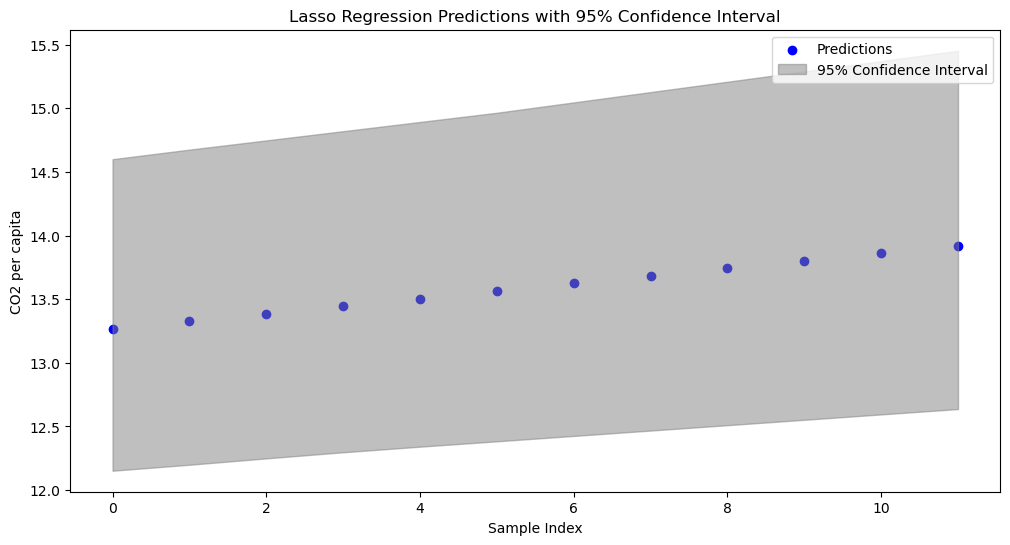

In [60]:
plt.figure(figsize=(12, 6))
plt.scatter(np.arange(len(prediction_lasso_without)), prediction_lasso_without, label='Predictions', color='b')

plt.fill_between(np.arange(len(prediction_lasso_without)), lower_bound, upper_bound, color='gray', alpha=0.5, label='95% Confidence Interval')

plt.xlabel('Sample Index')
plt.ylabel('CO2 per capita')
plt.title('Lasso Regression Predictions with 95% Confidence Interval')
plt.legend()
plt.show()

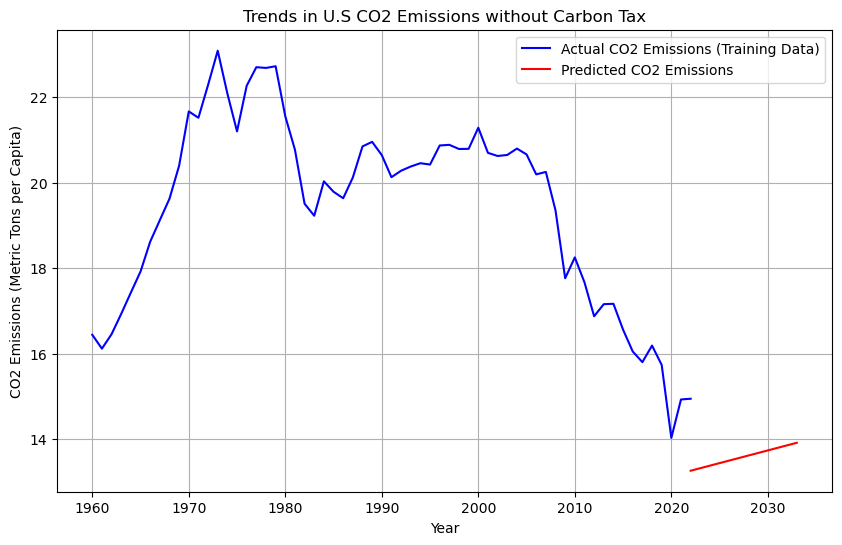

In [62]:
import matplotlib.pyplot as plt

# Extracting the actual CO2 emissions from the training data for the US
us_train = train[train['Country'] == 'United States']
actual_co2_us = us_train['CO2_per_capita']

# Define the range for x-axis starting from 2022
start_year = 2022
years = range(start_year, start_year + len(prediction_lasso_without))

# Plotting both actual and predicted CO2 emissions
plt.figure(figsize=(10, 6))

# Plotting the actual CO2 emissions from the training data
plt.plot(us_train['Year'], actual_co2_us, color='blue', label='Actual CO2 Emissions (Training Data)')

# Plotting the predicted CO2 emissions starting from 2022
plt.plot(years, prediction_lasso_without, color='red', label='Predicted CO2 Emissions')

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (Metric Tons per Capita)')
plt.title('Trends in U.S CO2 Emissions without Carbon Tax')
plt.legend()
plt.grid(True)
plt.show()

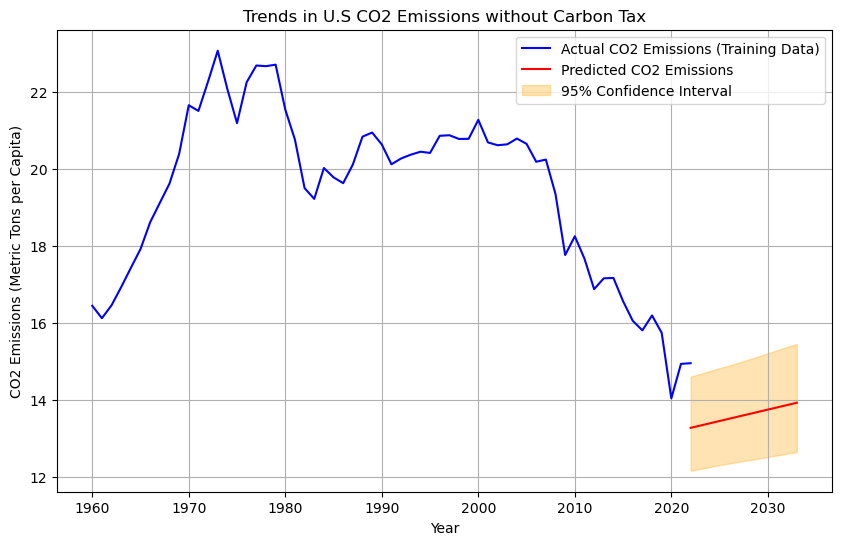

In [63]:
# Plot with Confidence Interval

us_train = train[train['Country'] == 'United States']
actual_co2_us = us_train['CO2_per_capita']

start_year = 2022
years = range(start_year, start_year + len(prediction_lasso_without))

plt.figure(figsize=(10, 6))

plt.plot(us_train['Year'], actual_co2_us, color='blue', label='Actual CO2 Emissions (Training Data)')

plt.plot(years, prediction_lasso_without, color='red', label='Predicted CO2 Emissions')

plt.fill_between(years, lower_bound, upper_bound, color='orange', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (Metric Tons per Capita)')
plt.title('Trends in U.S CO2 Emissions without Carbon Tax')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
upper_bound

array([14.60007289, 14.67530983, 14.7477566 , 14.82020337, 14.89265015,
       14.96509692, 15.04630582, 15.1275598 , 15.20881377, 15.29006775,
       15.37132173, 15.4525757 ])

In [65]:
lower_bound

array([12.15168025, 12.19860541, 12.24853769, 12.29672529, 12.34061012,
       12.38276393, 12.42504654, 12.46732915, 12.50961177, 12.55189438,
       12.59417699, 12.6364596 ])

# Test Dataset 2 

In [66]:
test2 = pd.DataFrame({'Year': range(2022, 2034)})
test2['Country'] = 'United States'

# Initialize CO2_per_capita and GDP columns with NaN values
test2['CO2_per_capita'] = pd.NA
test2['GDP'] = pd.NA
test2['CarbonTaxDummy'] = 1

# Calculate the average annual increase in GDP

gdp_diff = train.loc[train['Country'] == 'United States', 'GDP'].diff().mean()

if not train.empty:
    # Get the GDP value for the last available year in the train DataFrame for the United States
    last_year_gdp = train.loc[train['Country'] == 'United States', 'GDP'].max()

    # Calculate the GDP values for the years 2023 to 2032 based on the average increase
    test2.loc[test['Year'] >= 2022, 'GDP'] = last_year_gdp + gdp_diff * (test2['Year'] - train['Year'].max())

else:
    print("No data available for the United States in the train DataFrame.")

test2

,Year,Country,CO2_per_capita,GDP,CarbonTaxDummy
0,2022,United States,<NA>,76329.582265,1
1,2023,United States,<NA>,77512.202569,1
2,2024,United States,<NA>,78694.822872,1
3,2025,United States,<NA>,79877.443176,1
4,2026,United States,<NA>,81060.063479,1
5,2027,United States,<NA>,82242.683783,1
6,2028,United States,<NA>,83425.304086,1
7,2029,United States,<NA>,84607.92439,1
8,2030,United States,<NA>,85790.544694,1
9,2031,United States,<NA>,86973.164997,1


In [67]:
# Prepare X and y for training
X_train = train[['Year', 'GDP', 'CarbonTaxDummy']] 
y_train = train['CO2_per_capita']

# Prepare X for testing
X_test = test2[['Year', 'GDP', 'CarbonTaxDummy']]

# Scale the features
scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train)
X_test_scaled2 = scaler.transform(X_test)

# Initialize and train the Lasso regression model
alpha = 0.1  # Regularization strength
lasso = Lasso(alpha=alpha)
lasso.fit(X_train_scaled2, y_train)

# Predict CO2 emissions for test data
prediction_lasso_with = lasso.predict(X_test_scaled2)

prediction_lasso_with

array([11.69699249, 11.75633814, 11.81568378, 11.87502942, 11.93437506,
       11.9937207 , 12.05306634, 12.11241198, 12.17175762, 12.23110326,
       12.29044891, 12.34979455])

In [68]:
# Calculating Confidence Interval

n_bootstrap = 1000

bootstrap_predictions = np.zeros((len(X_test_scaled2), n_bootstrap))

# Perform bootstrapping
for i in range(n_bootstrap):
    # Resample with replacement
    indices = np.random.choice(len(X_train_scaled2), size=len(X_train_scaled2), replace=True)
    X_train_resampled = X_train_scaled2[indices]
    y_train_resampled = y_train[indices]
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_resampled, y_train_resampled)
    
    bootstrap_predictions[:, i] = lasso.predict(X_test_scaled2)

lower_bound = np.percentile(bootstrap_predictions, 2.5, axis=1)  # 2.5th percentile
upper_bound = np.percentile(bootstrap_predictions, 97.5, axis=1)  # 97.5th percentile

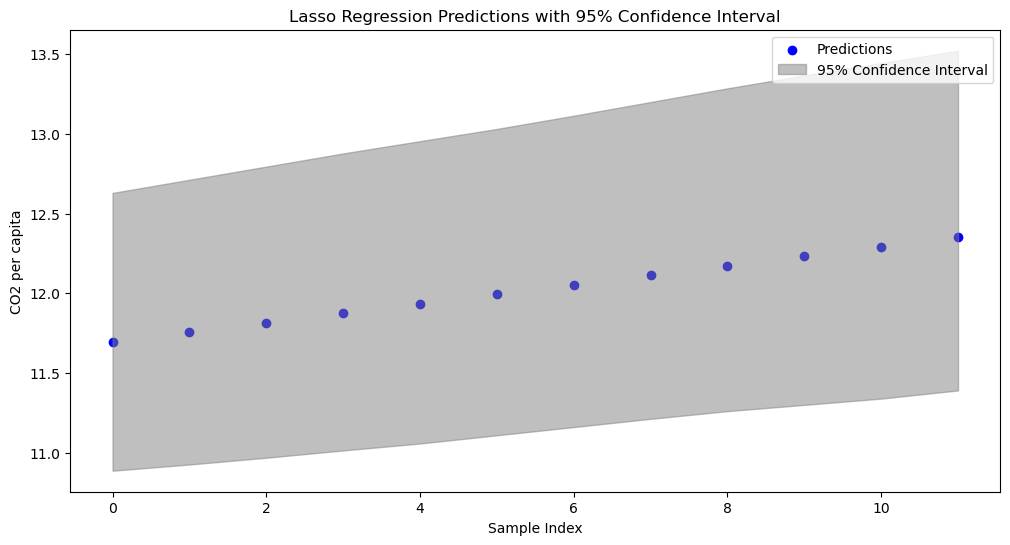

In [69]:
plt.figure(figsize=(12, 6))
plt.scatter(np.arange(len(prediction_lasso_with)), prediction_lasso_with, label='Predictions', color='b')

plt.fill_between(np.arange(len(prediction_lasso_with)), lower_bound, upper_bound, color='gray', alpha=0.5, label='95% Confidence Interval')

plt.xlabel('Sample Index')
plt.ylabel('CO2 per capita')
plt.title('Lasso Regression Predictions with 95% Confidence Interval')
plt.legend()
plt.show()

In [70]:
upper_bound

array([12.62904801, 12.71165312, 12.79425824, 12.87686335, 12.9539126 ,
       13.03045759, 13.11340342, 13.19931349, 13.28516141, 13.36581514,
       13.44349931, 13.52112441])

In [71]:
lower_bound 

array([10.88659447, 10.92558973, 10.96798372, 11.01371324, 11.0573023 ,
       11.10884273, 11.16038316, 11.21200303, 11.26029212, 11.29960565,
       11.33900055, 11.39023044])

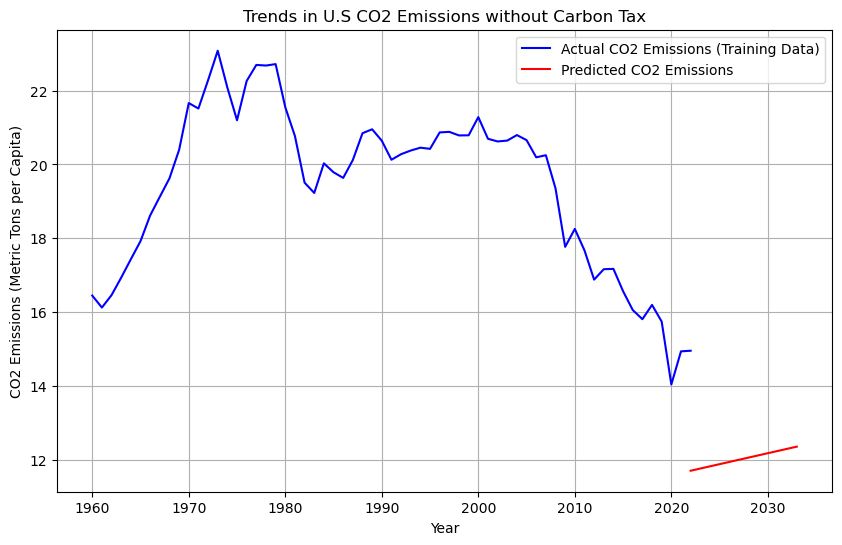

In [72]:
import matplotlib.pyplot as plt

# Extracting the actual CO2 emissions from the training data for the US
us_train = train[train['Country'] == 'United States']
actual_co2_us = us_train['CO2_per_capita']

# Define the range for x-axis starting from 2022
start_year = 2022
years = range(start_year, start_year + len(prediction_lasso_with))

# Plotting both actual and predicted CO2 emissions
plt.figure(figsize=(10, 6))

# Plotting the actual CO2 emissions from the training data
plt.plot(us_train['Year'], actual_co2_us, color='blue', label='Actual CO2 Emissions (Training Data)')

# Plotting the predicted CO2 emissions starting from 2022
plt.plot(years, prediction_lasso_with, color='red', label='Predicted CO2 Emissions')

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (Metric Tons per Capita)')
plt.title('Trends in U.S CO2 Emissions without Carbon Tax')
plt.legend()
plt.grid(True)
plt.show()

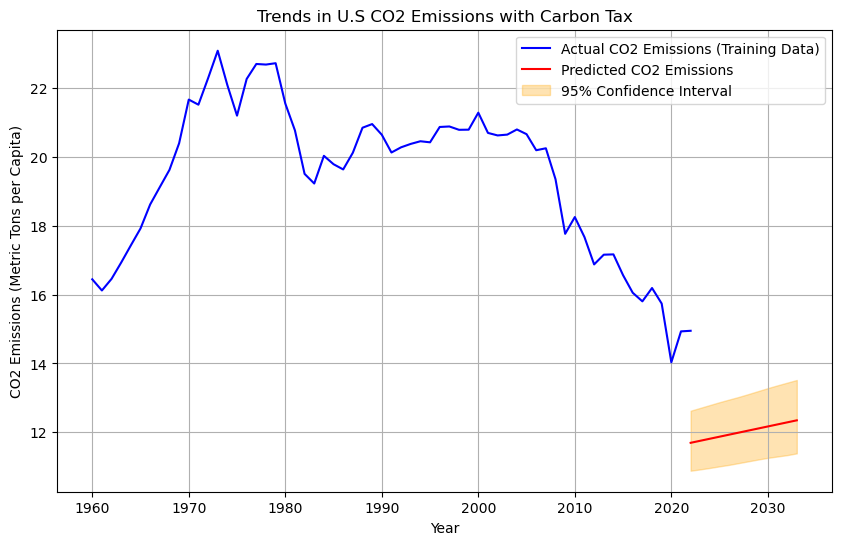

In [73]:
# Plot with Confidence Interval

# Plotting both actual and predicted CO2 emissions
plt.figure(figsize=(10, 6))

# Plotting the actual CO2 emissions from the training data
plt.plot(us_train['Year'], actual_co2_us, color='blue', label='Actual CO2 Emissions (Training Data)')

# Plotting the predicted CO2 emissions starting from 2022
plt.plot(years, prediction_lasso_with, color='red', label='Predicted CO2 Emissions')

# Plotting confidence intervals
plt.fill_between(years, lower_bound, upper_bound, color='orange', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (Metric Tons per Capita)')
plt.title('Trends in U.S CO2 Emissions with Carbon Tax')
plt.legend()
plt.grid(True)
plt.show()

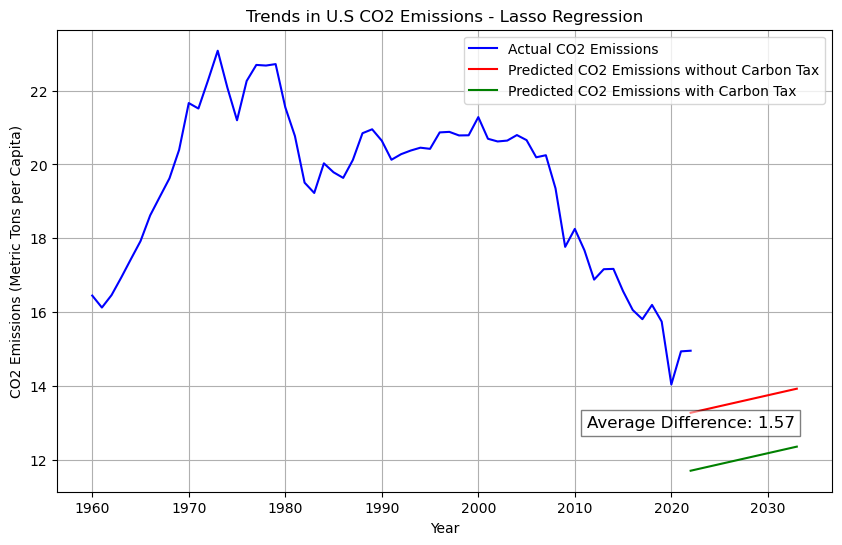

In [74]:
#Lasso Regression Comparison 

predictions_array = [11.69699249, 11.75633814, 11.81568378, 11.87502942, 11.93437506,
       11.9937207 , 12.05306634, 12.11241198, 12.17175762, 12.23110326,
       12.29044891, 12.34979455]

# Define the range for x-axis starting from 2022
start_year = 2022
years_array = range(start_year, start_year + len(predictions_array))

# Extracting the actual CO2 emissions from the training data for the US
us_train = train[train['Country'] == 'United States']
actual_co2_us = us_train['CO2_per_capita']

# Define the range for x-axis starting from 2022
start_year = 2022
years = range(start_year, start_year + len(prediction_lasso_without))

# Calculate the difference between prediction_lasso_without and predictions_array
difference = np.array(prediction_lasso_without) - np.array(predictions_array)

# Calculate the average difference
average_difference = np.mean(difference)

# Plotting both actual and predicted CO2 emissions
plt.figure(figsize=(10, 6))

# Plotting the actual CO2 emissions from the training data
plt.plot(us_train['Year'], actual_co2_us, color='blue', label='Actual CO2 Emissions')

# Plotting the predicted CO2 emissions starting from 2022
plt.plot(years, prediction_lasso_without, color='red', label='Predicted CO2 Emissions without Carbon Tax')

# Plotting the provided array against years starting from 2022
plt.plot(years_array, predictions_array, color='green', label='Predicted CO2 Emissions with Carbon Tax')

# Create a text box with the average difference information
textbox = f'Average Difference: {average_difference:.2f}'
plt.text(2022, 13, textbox, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5), ha='center', va='center')

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (Metric Tons per Capita)')
plt.title('Trends in U.S CO2 Emissions - Lasso Regression')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
# Carbon Tax Effect Confidence Interval

without_upper =  np.array([14.60007289, 14.67530983, 14.7477566 , 14.82020337, 14.89265015,
       14.96509692, 15.04630582, 15.1275598 , 15.20881377, 15.29006775,
       15.37132173, 15.4525757])
with_upper =  np.array([12.62904801, 12.71165312, 12.79425824, 12.87686335, 12.9539126 ,
       13.03045759, 13.11340342, 13.19931349, 13.28516141, 13.36581514,
       13.44349931, 13.52112441])

with_lower = np.array([10.88659447, 10.92558973, 10.96798372, 11.01371324, 11.0573023 ,
       11.10884273, 11.16038316, 11.21200303, 11.26029212, 11.29960565,
       11.33900055, 11.39023044])
without_lower =  np.array([12.15168025, 12.19860541, 12.24853769, 12.29672529, 12.34061012,
       12.38276393, 12.42504654, 12.46732915, 12.50961177, 12.55189438,
       12.59417699, 12.6364596])

co2_tax_effect = -1.57

# Calculate upper bound of final model
carbontax_upper = with_upper - without_lower + co2_tax_effect

# Calculate lower bound of final model
carbontax_lower = with_lower - without_lower + co2_tax_effect

# Print upper and lower bounds of final model for each year
for year, upper, lower in zip(range(2024, 2034), carbontax_upper, carbontax_lower):
    print(f"Year: {year}, Upper Bound: {upper}, Lower Bound: {lower}")

Year: 2024, Upper Bound: -1.0926322400000001, Lower Bound: -2.83508578
Year: 2025, Upper Bound: -1.0569522900000015, Lower Bound: -2.8430156800000006
Year: 2026, Upper Bound: -1.0242794499999996, Lower Bound: -2.85055397
Year: 2027, Upper Bound: -0.9898619399999988, Lower Bound: -2.8530120500000002
Year: 2028, Upper Bound: -0.9566975199999985, Lower Bound: -2.8533078199999995
Year: 2029, Upper Bound: -0.9223063400000002, Lower Bound: -2.8439212000000005
Year: 2030, Upper Bound: -0.8816431200000012, Lower Bound: -2.8346633800000003
Year: 2031, Upper Bound: -0.8380156599999997, Lower Bound: -2.8253261199999997
Year: 2032, Upper Bound: -0.7944503599999988, Lower Bound: -2.819319649999999
Year: 2033, Upper Bound: -0.7560792399999998, Lower Bound: -2.8222887300000004


# Ridge Regression 

In [76]:
# Test Dataset 1 
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge


# Define a range of alpha values to try
alphas = np.logspace(-4, 4, 100)  # Example range of alpha values

# Initialize RidgeCV with the range of alpha values
ridge_cv = RidgeCV(alphas=alphas, cv=5)  # 5-fold cross-validation

# Train the RidgeCV model
ridge_cv.fit(X_train_scaled, y_train)

# Get the optimal alpha value chosen by cross-validation
optimal_alpha = ridge_cv.alpha_
print("Optimal Alpha:", optimal_alpha)

# Initialize Ridge with the optimal alpha
ridge_tuned = Ridge(alpha=optimal_alpha)

# Train the tuned Ridge model
ridge_tuned.fit(X_train_scaled, y_train)

# Predict CO2 emissions for test data using the tuned model
prediction_ridge_without = ridge_tuned.predict(X_test_scaled)
prediction_ridge_without

Optimal Alpha: 1873.8174228603868


array([10.88943185, 10.92790686, 10.96638186, 11.00485687, 11.04333187,
       11.08180688, 11.12028189, 11.15875689, 11.1972319 , 11.2357069 ,
       11.27418191, 11.31265691])

In [77]:
# Test Dataset 2 

# Define a range of alpha values to try
alphas = np.logspace(-4, 4, 100)  # Example range of alpha values

# Initialize RidgeCV with the range of alpha values
ridge_cv = RidgeCV(alphas=alphas, cv=5)  # 5-fold cross-validation

# Train the RidgeCV model
ridge_cv.fit(X_train_scaled2, y_train)

# Get the optimal alpha value chosen by cross-validation
optimal_alpha = ridge_cv.alpha_
print("Optimal Alpha:", optimal_alpha)

# Initialize Ridge with the optimal alpha
ridge_tuned = Ridge(alpha=optimal_alpha)

# Train the tuned Ridge model
ridge_tuned.fit(X_train_scaled2, y_train)

prediction_ridge_with = ridge_tuned.predict(X_test_scaled2)
prediction_ridge_with

Optimal Alpha: 1873.8174228603868


array([10.29044682, 10.32892183, 10.36739684, 10.40587184, 10.44434685,
       10.48282185, 10.52129686, 10.55977186, 10.59824687, 10.63672188,
       10.67519688, 10.71367189])

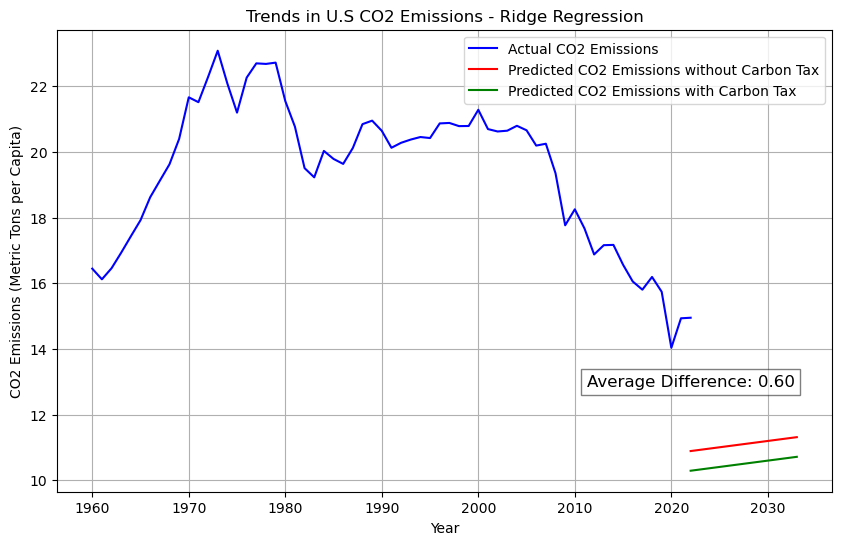

In [78]:
#Ridge Regression Comparison 

predictions_array = [10.29044682, 10.32892183, 10.36739684, 10.40587184, 10.44434685,
       10.48282185, 10.52129686, 10.55977186, 10.59824687, 10.63672188,
       10.67519688, 10.71367189]

start_year = 2022
years_array = range(start_year, start_year + len(predictions_array))

us_train = train[train['Country'] == 'United States']
actual_co2_us = us_train['CO2_per_capita']

start_year = 2022
years = range(start_year, start_year + len(prediction_lasso_without))

difference = np.array(prediction_ridge_without) - np.array(predictions_array)

average_difference = np.mean(difference)

plt.figure(figsize=(10, 6))

plt.plot(us_train['Year'], actual_co2_us, color='blue', label='Actual CO2 Emissions')

plt.plot(years, prediction_ridge_without, color='red', label='Predicted CO2 Emissions without Carbon Tax')

plt.plot(years_array, predictions_array, color='green', label='Predicted CO2 Emissions with Carbon Tax')

textbox = f'Average Difference: {average_difference:.2f}'
plt.text(2022, 13, textbox, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5), ha='center', va='center')

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (Metric Tons per Capita)')
plt.title('Trends in U.S CO2 Emissions - Ridge Regression')
plt.legend()
plt.grid(True)
plt.show()